# API demonstration for paper of v1.0

_the LSST-DESC CLMM team_


Here we demonstrate how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster when source galaxies follow a given distribution (the Chang. (2013) implemented in `clmm`). It uses several functionalities of the support `mock_data` module to produce mock datasets.

- Setting things up, with the proper imports.
- Computing the binned reduced tangential shear profile, for the 2 datasets, using logarithmic binning.
- Setting up a model accounting for the redshift distribution.
- Perform a simple fit using `scipy.optimize.curve_fit` and visualize the results.

## Setup

First, we import some standard packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = ['gothambook','gotham','gotham-book','serif']

Next, we import `clmm`'s core modules.

In [2]:
import clmm
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
import clmm.support.mock_data as mock
from clmm import Cosmology

## Measuring shear profiles 

`clmm` has a support code to generate a mock catalog given a input cosmology and cluster parameters. We will use this to generate a data sample to be used in this example:

In [151]:
np.random.seed(11) # For reproducibility

# Set cosmology of mock data
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)

# Cluster info
cluster_m = 1.e15 # Cluster mass - ($M200_m$) [Msun]
concentration = 4  # Cluster concentration
cluster_z = 0.3 # Cluster redshift
cluster_ra = 0. # Cluster Ra in deg
cluster_dec = 0. # Cluster Dec in deg

# Make mock galaxies

mock_galaxies = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,
                                               'chang13', zsrc_min=cluster_z+0.1, zsrc_max=7.0,
                                              shapenoise=0.05,
                                              ngal_density=25)['ra', 'dec', 'e1', 'e2', 'z', 'ztrue', 'id']

print(f'This results in a table with the columns: {", ".join(mock_galaxies.colnames)}')
len(mock_galaxies)

This results in a table with the columns: ra, dec, e1, e2, z, ztrue, id


19036

We can extract the column of this mock catalog to show explicitely how the quantities can be used on `clmm` functionality and how to add them to a `GalaxyCluster` object: 

In [152]:
# Create a GalaxyCluster
cluster = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec,
                                   cluster_z, mock_galaxies)

# Convert elipticities into shears for the members
cluster.compute_tangential_and_cross_components(geometry="flat")
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster
cluster.make_radial_profile(bins=da.make_bins(0.03, 7, 50, method='evenlog10width'),
                            bin_units="Mpc",
                            cosmo=cosmo,
                            include_empty_bins=False,
                            gal_ids_in_bins=True,
                           )
print(cluster.profile.colnames)

['ra', 'dec', 'e1', 'e2', 'z', 'ztrue', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'gal_id']


/pbs/home/c/ccombet/.conda/envs/mydesc3/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


This resoults in an attribute `table` added to the `cluster` object.

[3.543307086614173, 3.543307086614173]


<Figure size 1800x1200 with 0 Axes>

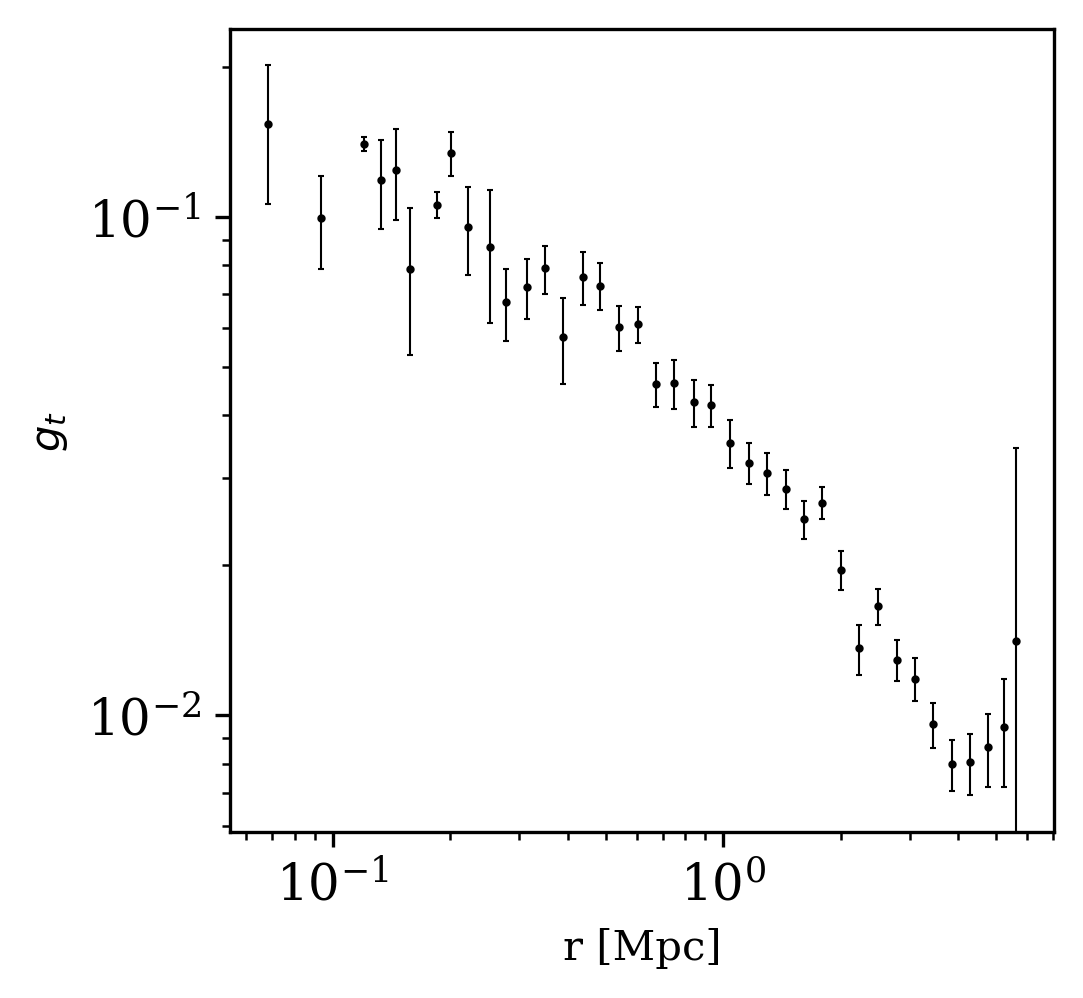

In [153]:
from paper_formating import prep_plot
prep_plot(figsize=(9, 9))

plt.errorbar(cluster.profile['radius'], cluster.profile['gt'],
             cluster.profile['gt_err'], c='k', linestyle='', marker='o',
            markersize=1, elinewidth=.5, capthick=.5)
plt.xlabel('r [Mpc]', fontsize = 10)
plt.ylabel(r'$g_t$', fontsize = 10)
plt.xscale('log')
plt.yscale('log')

#plt.xlim(min(cl_noisy.profile['radius']), max(cl_noisy.profile['radius']))

## Theoretical predictions

We consider 2 models:
1. One model using the overall source redshift distribution to predict the reduced tangential shear
2. A more accurate model, relying on the fact that we have access to the individual redshifts of the sources, where the average reduced tangential shear is averaged independently in each bin, accounting for the acutal population of sources in each bin.

Both models rely on `clmm.predict_reduced_tangential_shear` to make a prediction that accounts for the redshift distribution of the galaxies in each radial bin:

### Model relying on the overall redshif distribution of the sources, not using individual redshift information, i.e. approximate model

In [154]:
z_inf = 1000
dl_inf = cosmo.eval_da_z1z2(cluster_z, z_inf)
d_inf = cosmo.eval_da(z_inf)

def betas(z):
    dls = cosmo.eval_da_z1z2(cluster_z, z)
    ds = cosmo.eval_da(z)
    return dls * d_inf / (ds * dl_inf)

def betas_mean(z_src):
    return np.mean(betas(z_src))

def betas2_mean(z_src):
    return np.mean(betas(z_src)*betas(z_src))

def predict_reduced_tangential_shear_approx(profile, logm):

    bs_mean = betas_mean(cluster.galcat['z'])
    bs2_mean = betas2_mean(cluster.galcat['z'])

    gamma_t_inf = []
    convergence_inf = []
    for radial_bin in profile:
        r_proj = radial_bin['radius']
        gamma_t_inf.append(clmm.compute_tangential_shear(
            r_proj=r_proj, # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=z_inf, # Redshift value of each source galaxy inside the radial bin
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw'))
        convergence_inf.append(clmm.compute_tangential_shear(
            r_proj=r_proj, # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=z_inf, # Redshift value of each source galaxy inside the radial bin
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw'))
        
    return bs_mean * np.array(gamma_t_inf) / (1- (bs2_mean/bs_mean)*np.array(convergence_inf))    

### Model using individual redshift information, to compute the averaged shear in each radial bin, based on the galaxies actually present in that bin.

In [155]:
def predict_reduced_tangential_shear_exact(profile, logm):
    return np.array([np.mean(
        clmm.compute_reduced_tangential_shear(
            r_proj=radial_bin['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=cluster.galcat[radial_bin['gal_id']]['z'], # Redshift value of each source galaxy inside the radial bin
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw'
        )) for radial_bin in profile])

## Mass fitting

We estimate the best-fit mass using `scipy.optimize.curve_fit`.  We compare estimated mass for noisy and ideal data, using both models described above (naive with average redshift or the model taking into account the redshift distribution). The choice of fitting $\log_{10} M$ instead of $M$ lowers the range of pre-defined fitting bounds from several order of magnitude for the mass to unity. From the associated error $\Delta (\log_{10}M)$ we calculate the error to mass as $\Delta M = M_{fit}\log(10)\Delta (\log_{10}M)$.

In [156]:
from clmm.support.sampler import fitters
popt, pcov = fitters['curve_fit'](predict_reduced_tangential_shear_exact,
    cluster.profile, 
    cluster.profile['gt'], 
    cluster.profile['gt_err'], bounds=[10.,17.])

logm_est, logm_err_est = popt[0], np.sqrt(pcov[0][0])

m_est_exact = 10.**logm_est
m_est_exact_err =  m_est*logm_err_est*np.log(10)

In [157]:
print(f'The input mass = {cluster_m:.2e} Msun\n')

print("Accounting for the redshift distribution in the model\n")
print(f'Best fit mass for noisy data = {m_est_exact:.2e} +/- {m_est_exact_err:.2e} Msun')

The input mass = 1.00e+15 Msun

Accounting for the redshift distribution in the model

Best fit mass for noisy data = 1.02e+15 +/- 3.09e+13 Msun


In [158]:
popt, pcov = fitters['curve_fit'](predict_reduced_tangential_shear_approx,
    cluster.profile, 
    cluster.profile['gt'], 
    cluster.profile['gt_err'], bounds=[10.,17.])

logm_est, logm_err_est = popt[0], np.sqrt(pcov[0][0])

m_est_approx = 10.**logm_est
m_est_approx_err =  m_est*logm_err_est*np.log(10)

In [159]:
print(f'The input mass = {cluster_m:.2e} Msun\n')

print("Accounting for the redshift distribution in the model\n")
print(f'Best fit mass for noisy data = {m_est_approx:.2e} +/- {m_est_approx_err:.2e} Msun')

The input mass = 1.00e+15 Msun

Accounting for the redshift distribution in the model

Best fit mass for noisy data = 1.09e+15 +/- 5.95e+13 Msun


As expected, the reconstructed mass is biased when the redshift distribution is not accounted for in the model

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model with estimated masses for noisy and ideal data.

In [160]:
gt_est = predict_reduced_tangential_shear_exact(cluster.profile, logm_est)
gt_est_err = [predict_reduced_tangential_shear_exact(cluster.profile, logm_est+i*logm_err_est)
                      for i in (-3, 3)]

gt_est_approx = predict_reduced_tangential_shear_approx(cluster.profile, logm_est)
gt_est_approx_err = [predict_reduced_tangential_shear_approx(cluster.profile, logm_est+i*logm_err_est)
                      for i in (-3, 3)]

We compare to tangential shear obtained with theoretical mass. We plot the reduced tangential shear models first when redshift distribution is accounted for in the model then for the naive approach, with respective best-fit masses.

[3.543307086614173, 3.543307086614173]


<Figure size 1800x1200 with 0 Axes>

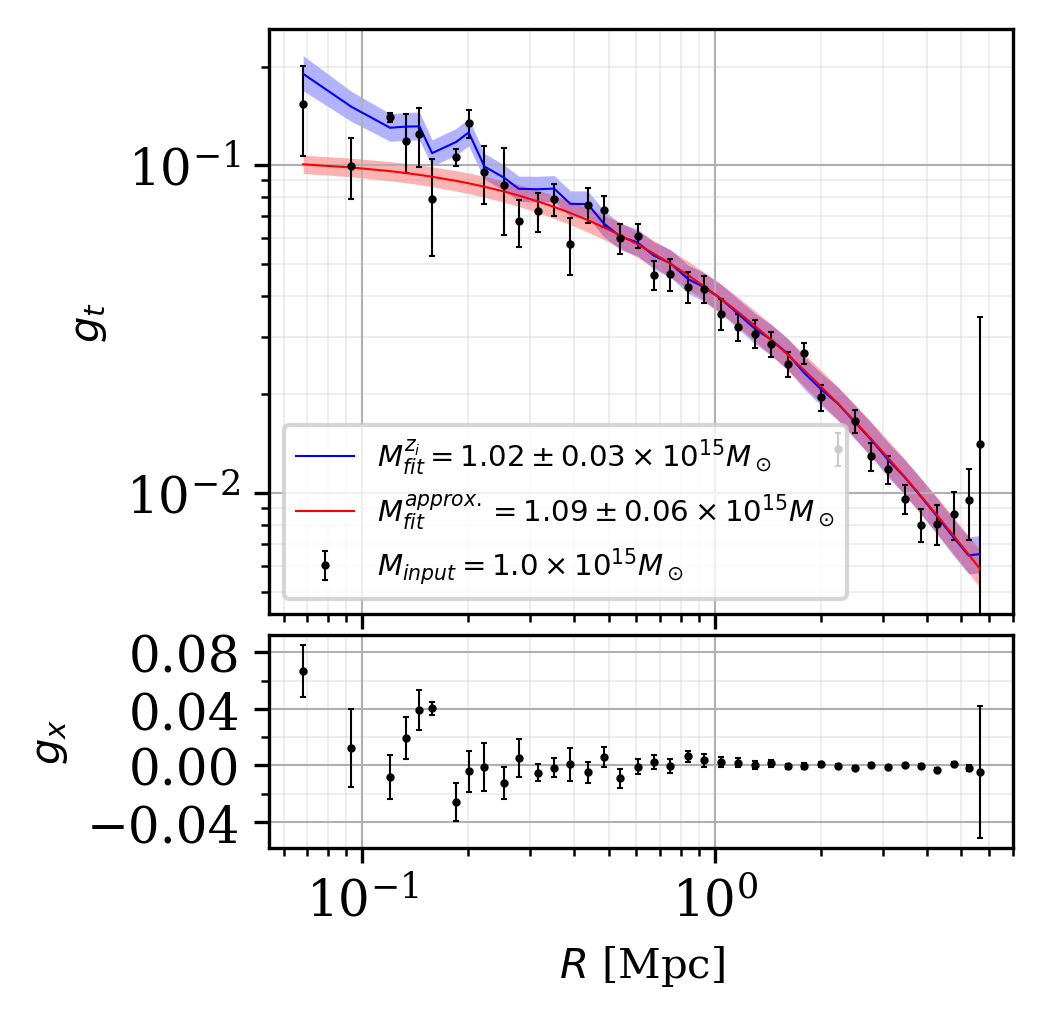

In [161]:
from matplotlib.ticker import MultipleLocator
prep_plot(figsize=(9 , 9))
gt_ax = plt.axes([.25, .42, .7, .55])
gt_ax.errorbar(cluster.profile['radius'], cluster.profile['gt'], cluster.profile['gt_err'],
             c='k', linestyle='', marker='o', label=rf'$M_{{input}} = {cluster_m*1e-15}\times10^{{{15}}} M_\odot$',
            markersize=1, elinewidth=.5, capthick=.5)
pow10 = 15
gt_ax.loglog(cluster.profile['radius'], gt_est,'-b', 
           label=fr'$M_{{fit}}^{{z_i}}= {m_est_exact/10**pow10:.2f} \pm {m_est_exact_err/10**pow10:.2f}\times 10^{{{pow10}}} M_\odot$',
          lw=.5)
gt_ax.fill_between(cluster.profile['radius'], *gt_est_err, lw=0, color='b', alpha=.3)
gt_ax.loglog(cluster.profile['radius'], gt_est_approx,'-r', 
           label=fr'$M_{{fit}}^{{approx.}} = {m_est_approx/10**pow10:.2f} \pm {m_est_approx_err/10**pow10:.2f}\times 10^{{{pow10}}} M_\odot$',
          lw=.5)
gt_ax.fill_between(cluster.profile['radius'], *gt_est_approx_err, lw=0, color='r', alpha=.3)
gt_ax.set_ylabel(r'$g_t$', fontsize = 10)
gt_ax.legend(fontsize=7)
gt_ax.set_xticklabels([])

gx_ax = plt.axes([.25, .2, .7, .2])
gx_ax.errorbar(cluster.profile['radius'], cluster.profile['gx'], cluster.profile['gx_err'],
             c='k', linestyle='', marker='o',
            markersize=1, elinewidth=.5, capthick=.5)
gx_ax.set_xlabel('$R$ [Mpc]', fontsize = 10)
gx_ax.set_ylabel(r'$g_x$', fontsize = 10)
gx_ax.set_xscale('log')
gx_ax.set_xlim(gt_ax.get_xlim())
gx_ax.yaxis.set_major_locator(MultipleLocator(.04))
gx_ax.yaxis.set_minor_locator(MultipleLocator(.02))

for p in (gt_ax, gx_ax):
    p.xaxis.grid(True, which='major', lw=.5)
    p.yaxis.grid(True, which='major', lw=.5)
    p.xaxis.grid(True, which='minor', lw=.1)
    p.yaxis.grid(True, which='minor', lw=.1)

plt.savefig('r_gt.png')